# Processing scRNA-seq Data
* Preprocessing Clayton's VANTAGE data using `dropkick` to determine quality of data
* Integrating and correcting reference cell lines with AW data using `scanorama`
Adapted from: https://github.com/smgroves/Groves-CellSys2021/blob/main/notebooks/single-cell/cell-lines/1-Human_cell_lines_preprocessing.ipynb

In [1]:
import os
import sys
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import dropkick as dk
import cellrank as cr
import scanorama
from mazebox_filter import dropkick_filter, dropkick_recipe, doublet_detections

###  Read in counts data

In [2]:
# Load data
REF_DATA = '/mnt/monica/quaranta/Data/RNAseq/SCLC_data/SCLC_scRNAseq/SCLC-human-cell-lines-Vanderbilt/adata_no_doublets_02.h5ad'
ref_adata = sc.read_h5ad(REF_DATA)

MTX_DIR = '/mnt/monica/quaranta2/Sequence_data_from_VANTAGE/CW-AW_data/processed_data_Qi_Liu'
sample_names = os.listdir(MTX_DIR)
sample_names.sort()
sample_names = sample_names[2:12]

| Sample Info | Output Dir |
| ------------| ------------|
| S1 H841_KOR  | 8056-AW-0001 |
| S2 H841_RESTko | 8056-AW-0002 |
| S3 H841_Hes1ko | 8056-AW-0003 | 
| S4 H841_NR0B1ko | 8056-AW-0004 |
| S5 H841_ELF3ko | 8056-AW-0005 |
| S1 DMS53_KOR | 8056-AW-0006 |
| S2 DMS53_RESTko | 8056-AW-0007 |
| S3 DMS53_Hes1ko | 8056-AW-0008 |
| S4 DMS53_NR0B1ko | 8056-AW-0009 |
| S5 DMS53_ELF3ko | 8056-AW-0010 |

In [3]:
# H841 - samples[0:5]
# DMS53 - samples[5:10]
cache = False
cache_compression = None
samples = []

for sample in sample_names[5:10]:
    print(sample)
    s = sc.read(
        f'{MTX_DIR}/{sample}/cm_sparse/{sample}_S1_L005_counts.mtx',
        cache=cache,
        cache_compression=cache_compression,
    ).T
    
    genes = pd.read_csv(f'{MTX_DIR}/{sample}/cm_sparse/{sample}_S1_L005_features.tsv', header=None, sep='\t')
    s.var_names = genes[0]
    # s.var['gene_symbols'] = genes[1].values
    s.obs_names = pd.read_csv(f'{MTX_DIR}/{sample}/cm_sparse/{sample}_S1_L005_barcodes.tsv', header=None)[0]
    print(s)
    samples.append(s)

8056-AW-0006
AnnData object with n_obs × n_vars = 12622 × 25828
8056-AW-0007
AnnData object with n_obs × n_vars = 13303 × 25856
8056-AW-0008
AnnData object with n_obs × n_vars = 5038 × 24030
8056-AW-0009
AnnData object with n_obs × n_vars = 7962 × 26426
8056-AW-0010
AnnData object with n_obs × n_vars = 10536 × 26090


In [4]:
total_cells = 0
for i,a in enumerate(samples):
    print(sample_names[i])
    print(a.X.shape)
    total_cells += a.X.shape[0]
print("Total cells: ", total_cells)

8056-AW-0001
(12622, 25828)
8056-AW-0002
(13303, 25856)
8056-AW-0003
(5038, 24030)
8056-AW-0004
(7962, 26426)
8056-AW-0005
(10536, 26090)
Total cells:  49461


In [5]:
s1, s2, s3, s4, s5 = samples

### Plot QC metrics
Simple preprocessing of anndata object to get metrics for plot. Running on each sample to determine quality and filtering for each sample before integrating.

**S1 DMS53_KOR (control)** 

In [11]:
adata1 = dk.recipe_dropkick(s1, n_hvgs=None, X_final="raw_counts")

Top 10 ambient genes have dropout rates between 5.997 and 18.349 percent:
	['LINC00486', 'MT-ND4', 'CALCA', 'SEC11C', 'CGA', 'MT-ND1', 'MT-CO1', 'BCOR', 'MT-CYB', 'RP5-857K21.4']


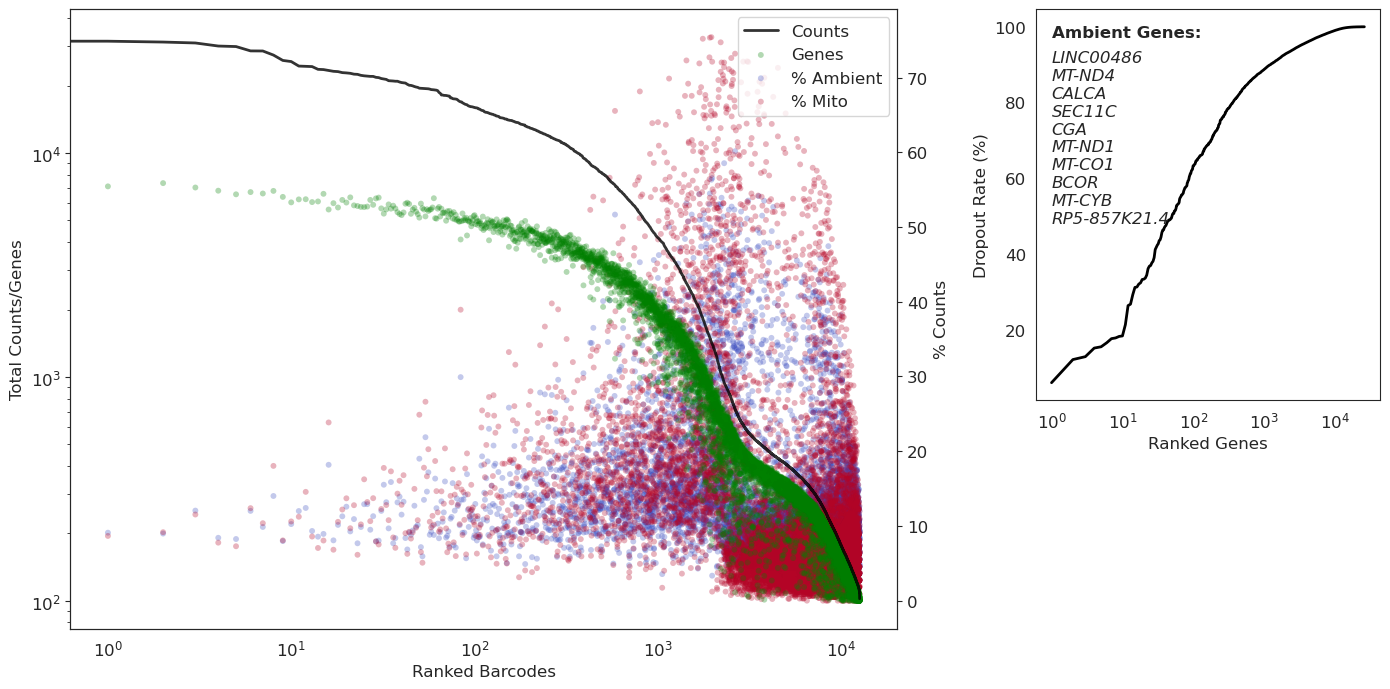

In [12]:
qc_plt1 = dk.qc_summary(adata1)

**S2 DMS53_RESTko**

In [17]:
a2 = dk.recipe_dropkick(s2, n_hvgs=None, X_final="raw_counts")

Top 10 ambient genes have dropout rates between 1.511 and 10.862 percent:
	['MT-ND4', 'RP5-857K21.4', 'MT-ND1', 'MT-CO1', 'MT-CO3', 'LINC00486', 'MT-CYB', 'MT-ATP6', 'MT-RNR2', 'MT-ND2']


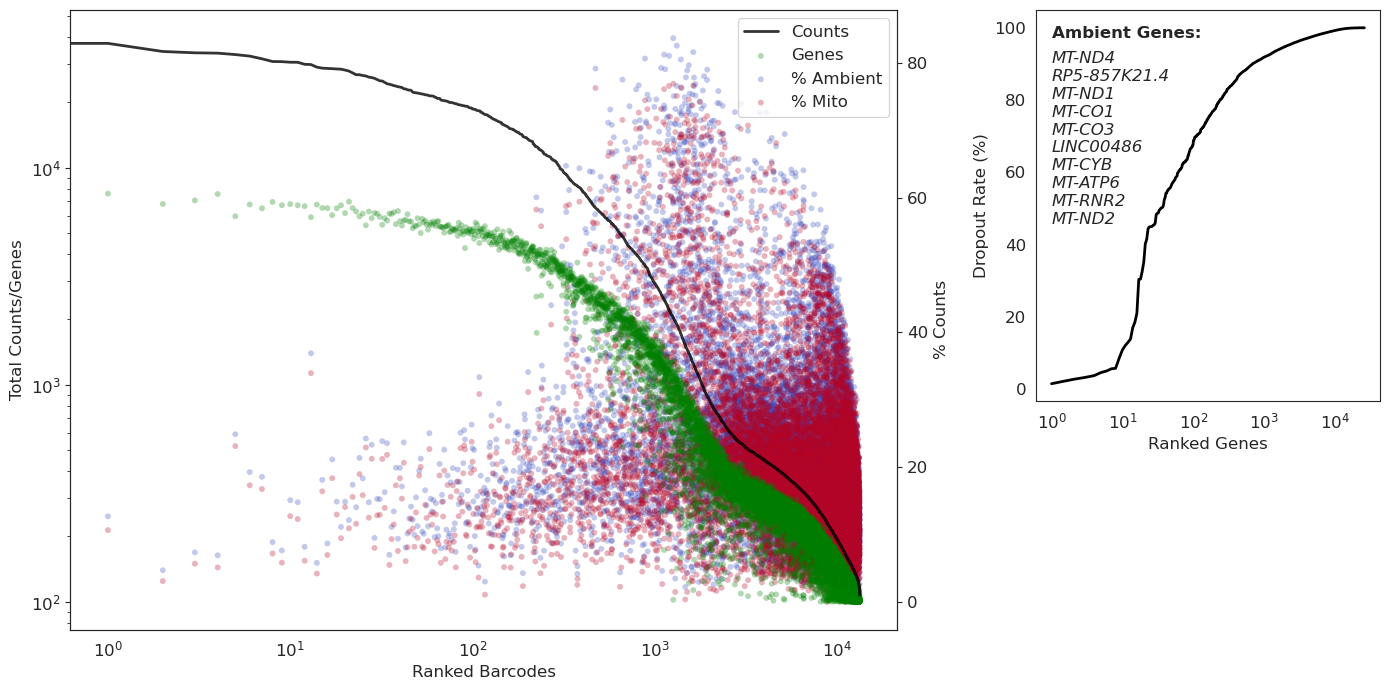

In [18]:
qc_plt2 = dk.qc_summary(a2)

**S3 DMS53_Hes1ko**

In [19]:
a3 = dk.recipe_dropkick(s3, n_hvgs=None, X_final="raw_counts")

Top 10 ambient genes have dropout rates between 0.357 and 11.632 percent:
	['LINC00486', 'RP5-857K21.4', 'MT-ND1', 'MT-ND4', 'MT-CO1', 'ZNF730', 'MT-CO3', 'MT-CYB', 'MT-ATP6', 'MT-ND2']


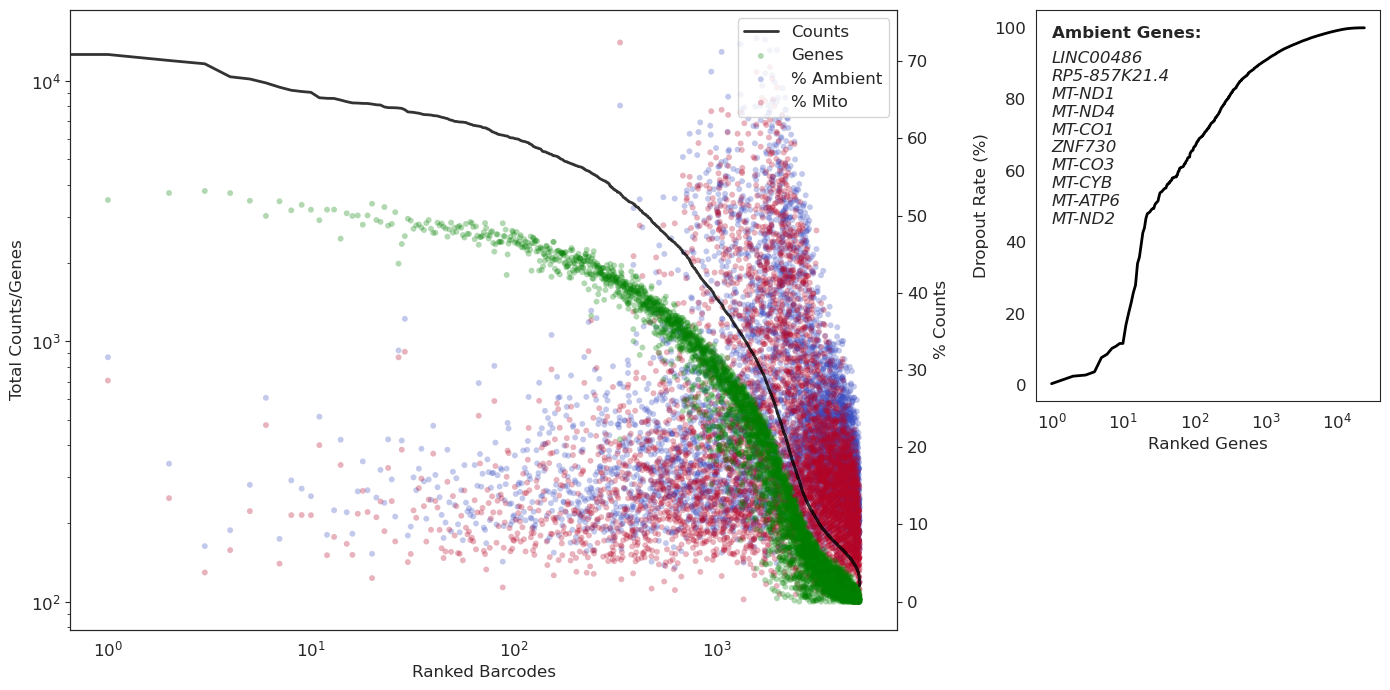

In [20]:
qc_plt3 = dk.qc_summary(a3)

**S4 DMS53_NR0B1ko**

In [21]:
a4 = dk.recipe_dropkick(s4, n_hvgs=None, X_final="raw_counts")

Top 10 ambient genes have dropout rates between 2.776 and 9.03 percent:
	['LINC00486', 'MT-ND4', 'MT-CO1', 'RP5-857K21.4', 'MT-ND1', 'MT-CO3', 'CALCA', 'MT-CYB', 'MT-ATP6', 'MT-ND2']


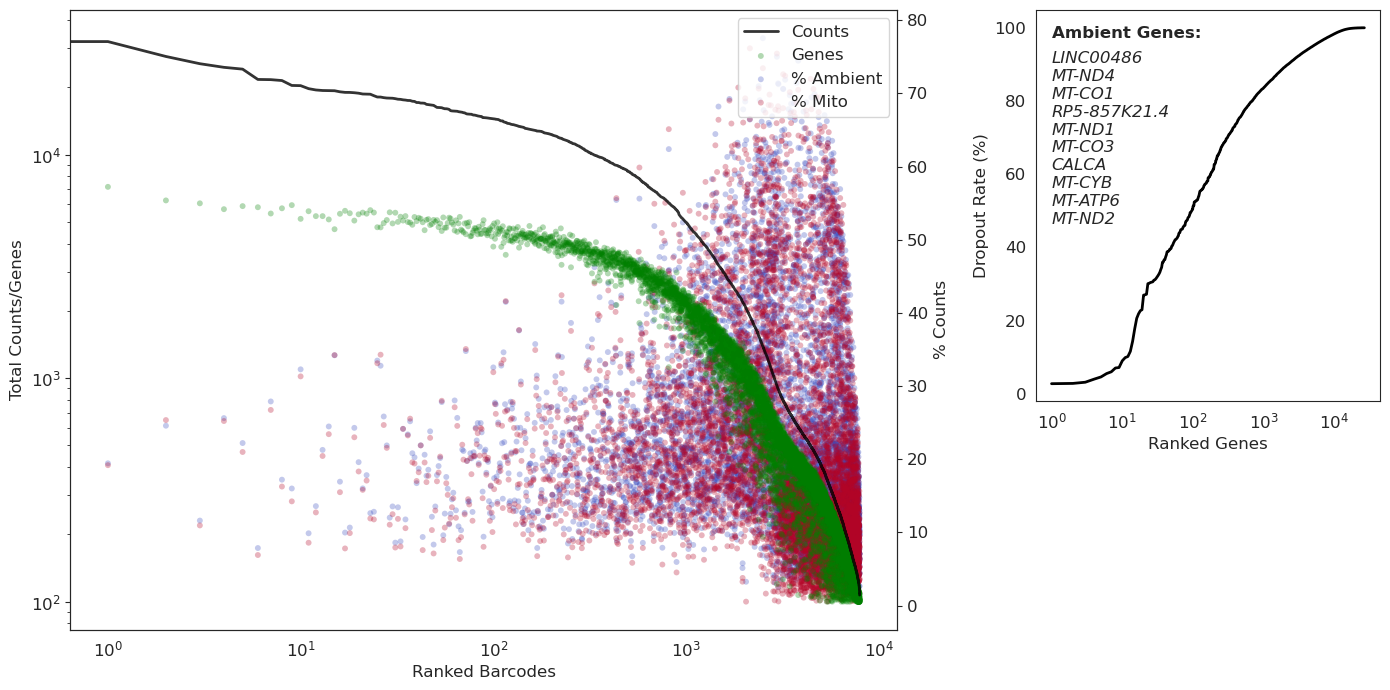

In [22]:
qc_plt4 = dk.qc_summary(a4)

**S5 DMS53_ELF3ko**

In [23]:
a5 = dk.recipe_dropkick(s5, n_hvgs=None, X_final="raw_counts")

Top 10 ambient genes have dropout rates between 1.86 and 10.232 percent:
	['LINC00486', 'MT-CO1', 'RP5-857K21.4', 'MT-ND4', 'CALCA', 'MT-ND1', 'MT-CO3', 'MT-RNR2', 'MT-CYB', 'CGA']


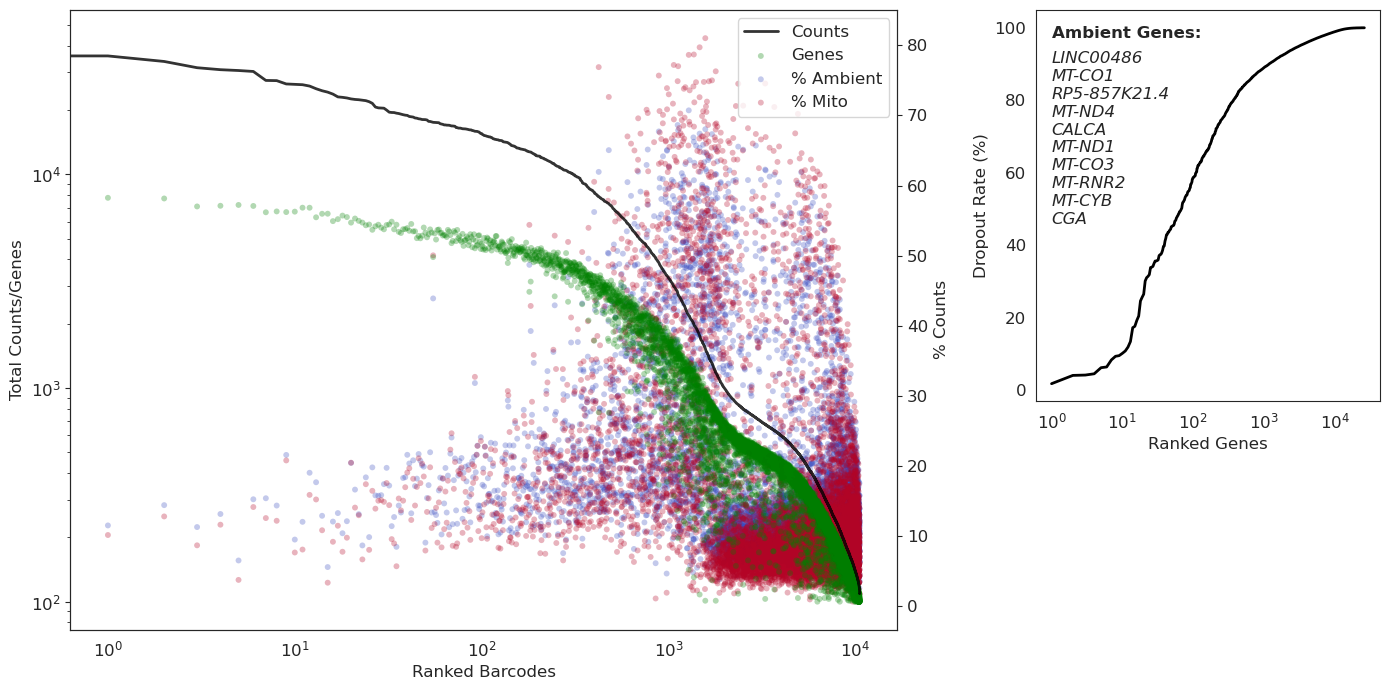

In [24]:
qc_plt5 = dk.qc_summary(a5)

In [6]:
batch_categories = ["S1 DMS53_KOR", "S2 DMS53_RESTko", "S3 DMS53_Hes1ko", "S4 DMS53_NR0B1ko", "S5 DMS53_ELF3ko"]
batch_key = "AW_DMS53_sample"
adata = dropkick_recipe([s1, s2, s3, s4, s5], verbose=True, filter=False, batch_categories=batch_categories, batch_key=batch_key, X_final='log1p_norm', plot=False, n_hvgs=None)

Running dropkick on each sample and filtering...
Top 10 ambient genes have dropout rates between 5.997 and 18.349 percent:
	['LINC00486', 'MT-ND4', 'CALCA', 'SEC11C', 'CGA', 'MT-ND1', 'MT-CO1', 'BCOR', 'MT-CYB', 'RP5-857K21.4']
Determining 2000 highly variable genes
Setting arcsinh_norm layer to .X
Thresholding on heuristics for training labels:
	['arcsinh_n_genes_by_counts']
Ignoring 5034 barcodes below first threshold on arcsinh_n_genes_by_counts
Training dropkick with alphas:
	[0.1]


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.1min finished


Chosen lambda value:
	[0.0263538]
Assigning scores and labels
Done!

Top 10 ambient genes have dropout rates between 1.511 and 10.862 percent:
	['MT-ND4', 'RP5-857K21.4', 'MT-ND1', 'MT-CO1', 'MT-CO3', 'LINC00486', 'MT-CYB', 'MT-ATP6', 'MT-RNR2', 'MT-ND2']
Determining 2000 highly variable genes
Setting arcsinh_norm layer to .X
Thresholding on heuristics for training labels:
	['arcsinh_n_genes_by_counts']
Ignoring 6074 barcodes below first threshold on arcsinh_n_genes_by_counts
Training dropkick with alphas:
	[0.1]


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.2min finished


Chosen lambda value:
	[0.02308213]
Assigning scores and labels
Done!

Top 10 ambient genes have dropout rates between 0.357 and 11.632 percent:
	['LINC00486', 'RP5-857K21.4', 'MT-ND1', 'MT-ND4', 'MT-CO1', 'ZNF730', 'MT-CO3', 'MT-CYB', 'MT-ATP6', 'MT-ND2']
Determining 2000 highly variable genes
Setting arcsinh_norm layer to .X
Thresholding on heuristics for training labels:
	['arcsinh_n_genes_by_counts']
Ignoring 2987 barcodes below first threshold on arcsinh_n_genes_by_counts
Training dropkick with alphas:
	[0.1]


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   12.1s finished


Chosen lambda value:
	[0.14073525]
Assigning scores and labels
Done!

Top 10 ambient genes have dropout rates between 2.776 and 9.03 percent:
	['LINC00486', 'MT-ND4', 'MT-CO1', 'RP5-857K21.4', 'MT-ND1', 'MT-CO3', 'CALCA', 'MT-CYB', 'MT-ATP6', 'MT-ND2']
Determining 2000 highly variable genes
Setting arcsinh_norm layer to .X
Thresholding on heuristics for training labels:
	['arcsinh_n_genes_by_counts']
Ignoring 2820 barcodes below first threshold on arcsinh_n_genes_by_counts
Training dropkick with alphas:
	[0.1]


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   48.5s finished


Chosen lambda value:
	[0.04179188]
Assigning scores and labels
Done!

Top 10 ambient genes have dropout rates between 1.86 and 10.232 percent:
	['LINC00486', 'MT-CO1', 'RP5-857K21.4', 'MT-ND4', 'CALCA', 'MT-ND1', 'MT-CO3', 'MT-RNR2', 'MT-CYB', 'CGA']
Determining 2000 highly variable genes
Setting arcsinh_norm layer to .X
Thresholding on heuristics for training labels:
	['arcsinh_n_genes_by_counts']
Ignoring 4434 barcodes below first threshold on arcsinh_n_genes_by_counts
Training dropkick with alphas:
	[0.1]


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   58.4s finished


Chosen lambda value:
	[0.02026937]
Assigning scores and labels
Done!

AnnData object with n_obs × n_vars = 49461 × 21758
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_DMS53_sample'
    var: 'dropkick_coef-S1 DMS53_KOR', 'dropkick_coef-S2 DMS53_RESTko', 'dropkick_coef-S3 DMS53_Hes1ko', 'dropkick_coef-S4 DMS53_NR0B1ko', 'dropkick_coef-S5 DMS53_ELF3ko'
Filtering and normalizing concatenated data...
Ignoring 37 barcodes with less than 100 genes detected
AnnData object with n_obs × n_vars = 49424 × 21758
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_DMS53_sample', 'initial_size'
    var: 'dropkick_coef-S1 DMS53_KOR', 'dropkick_coef-S2 DMS53_RESTko', 'dropkick_coef-S3 DMS53_Hes1ko', 'dropkick_coef-S4 DMS53_NR0B1ko', 'dropkick_coef-S5 DMS53_ELF3ko'
    layers: 'raw_counts'
Top 10 ambient genes have dropout rates between 3.753 and 15.146 percent:
	['LINC00486', 'MT-ND4', 'RP5-857K21.4', 'MT-ND1', 'MT-CO1', 'MT-CO3', 'MT-CYB', 'CAL

In [7]:
adata

AnnData object with n_obs × n_vars = 49424 × 21758
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_DMS53_sample', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase'
    var: 'dropkick_coef-S1 DMS53_KOR', 'dropkick_coef-S2 DMS53_RESTko', 'dropkick_coef-S3 DMS53_Hes1ko', 'dropkick_coef-S4 DMS53_NR0B1ko', 'dropkick_coef-S5 DMS53_ELF3ko', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'arcsinh_norm', 'log1p_norm'

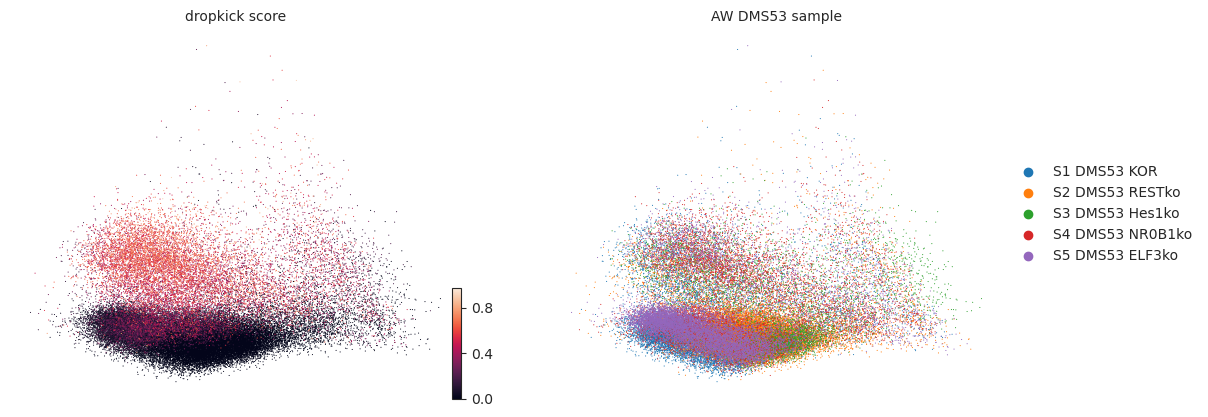

In [8]:
scv.pl.pca(adata, color = ['dropkick_score','AW_DMS53_sample'], legend_loc = 'on right')

In [9]:
scv.pp.neighbors(adata, random_state=0)
scv.tl.umap(adata, random_state=0)

computing neighbors
    finished (0:00:36) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


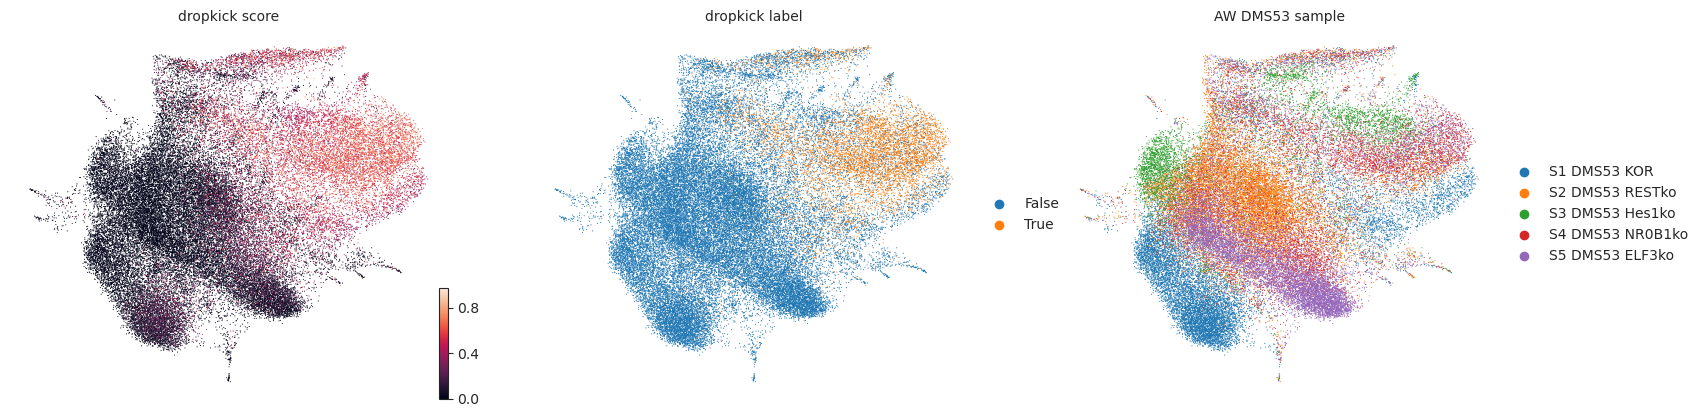

In [10]:
scv.pl.umap(adata, color = ['dropkick_score','dropkick_label','AW_DMS53_sample'], legend_loc = 'on right')

In [11]:
adata_dk = adata[adata.obs.dropkick_label=='True'].copy()

In [12]:
scv.pp.pca(adata_dk, random_state=0)

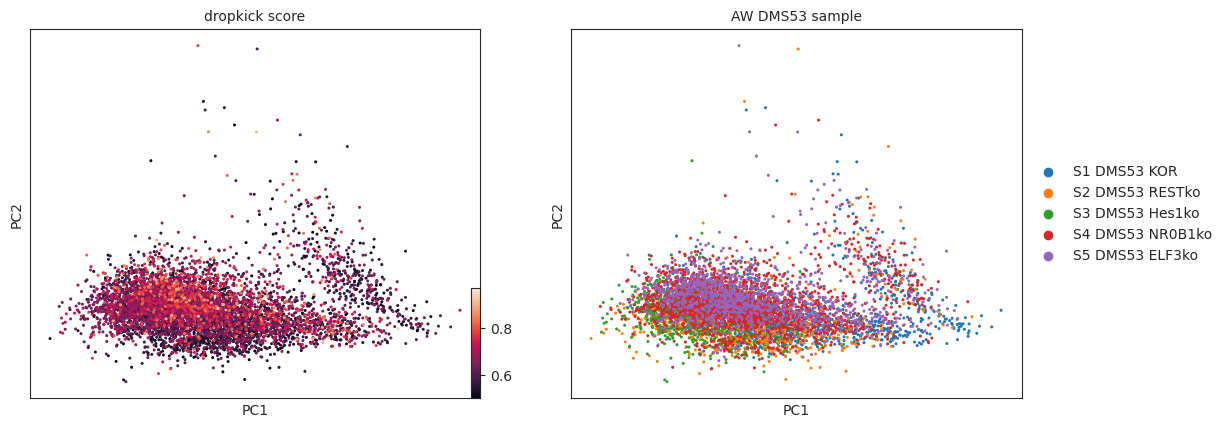

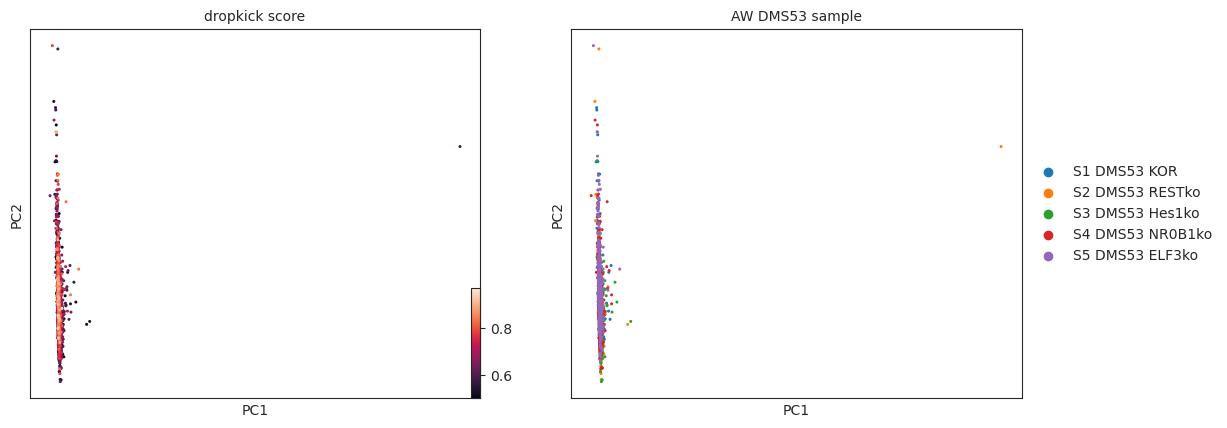

In [13]:
scv.pl.pca(adata_dk, color = ['dropkick_score','AW_DMS53_sample'], legend_loc = 'on right', components="1,2", frameon=True)
scv.pl.pca(adata_dk, color = ['dropkick_score','AW_DMS53_sample'], legend_loc = 'on right', components="3,2", frameon = True)

In [14]:
scv.pp.neighbors(adata_dk, random_state=0)
scv.tl.umap(adata_dk, random_state=0)

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


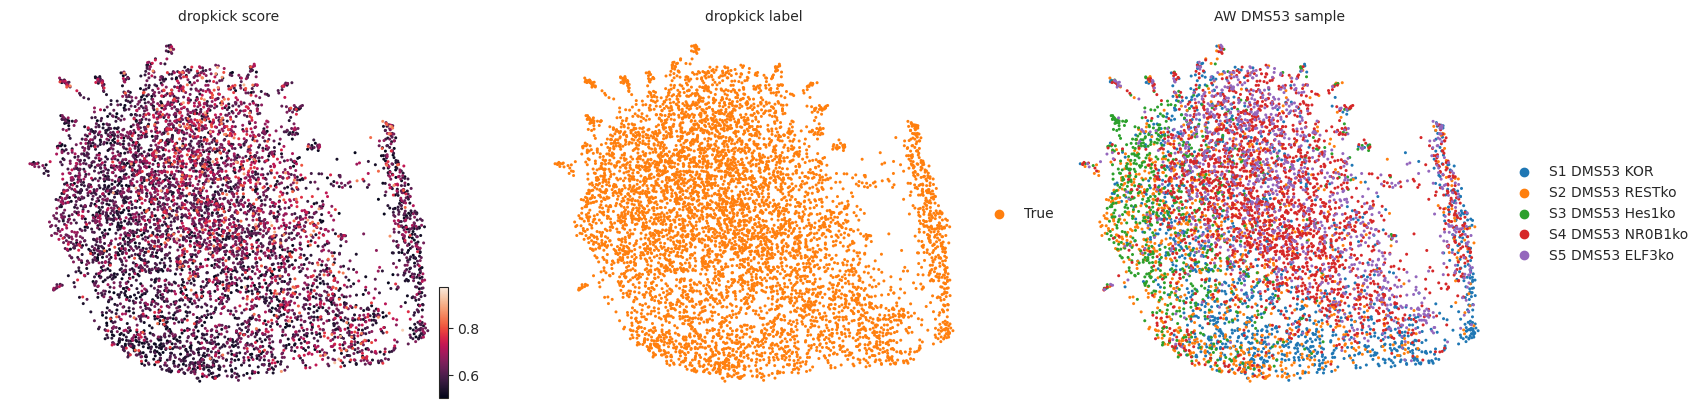

In [15]:
scv.pl.umap(adata_dk, color = ['dropkick_score','dropkick_label','AW_DMS53_sample'], legend_loc = 'on right')

In [16]:
adata_dk.write_h5ad('/home/monica/rna_seq/adata_dk_01.h5ad')

In [17]:
adata_dk

AnnData object with n_obs × n_vars = 6356 × 21758
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_DMS53_sample', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase'
    var: 'dropkick_coef-S1 DMS53_KOR', 'dropkick_coef-S2 DMS53_RESTko', 'dropkick_coef-S3 DMS53_Hes1ko', 'dropkick_coef-S4 DMS53_NR0B1ko', 'dropkick_coef-S5 DMS53_ELF3ko', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'pca', 'AW_DMS53_sample_colors', 'neighbors', 'umap', 'dropkick_label_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'arcsinh_norm', 'log1p_norm'
    obsp: 'distances', 'connectivities'

In [18]:
ref_adata

AnnData object with n_obs × n_vars = 13945 × 20446
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'cline', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_scores_ind', 'predicted_doublets_ind', 'M', 'E', 'clusters_gradients', 'cell_cycle_diff', 'score'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'dropkick_coef-CORL279', 'dropkick_coef-DMS454', 'dropkick_coef-DMS53', 'dropkick_coef-H1048', 'dropkick_coef-H524', 'dropkick_coef-H69', 'dropkick_coef-H82', 'dropkick_coef-H841', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_

### Integrate with scanorama

First trying `correct_scanp`y with the `adata_dk` and `ref_adata`

In [22]:
# correct between Clayton's samples and sarah's
batches = ['AW_DMS53_sample', 'ref_sample']

alldata = {}
alldata[batches[0]] = adata_dk
alldata[batches[1]] = ref_adata

# convert to list of AnnData objects
adatas = list(alldata.values())
adatas

[AnnData object with n_obs × n_vars = 6356 × 21758
     obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_DMS53_sample', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase'
     var: 'dropkick_coef-S1 DMS53_KOR', 'dropkick_coef-S2 DMS53_RESTko', 'dropkick_coef-S3 DMS53_Hes1ko', 'dropkick_coef-S4 DMS53_NR0B1ko', 'dropkick_coef-S5 DMS53_ELF3ko', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
     uns: 'pca', 'AW_DMS53_sample_colors', 'neighbors', 'umap', 'dropkick_label_colors'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'raw_counts', 'arcsinh_norm', 'log1p_norm'
     obsp: 'distances', 'connectivitie

In [23]:
corrected = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 15746 genes among all datasets
[[0.         0.25629327]
 [0.         0.        ]]
Processing datasets (0, 1)


In [24]:
corrected

[AnnData object with n_obs × n_vars = 6356 × 15746
     obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_DMS53_sample', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase'
     var: 'dropkick_coef-S1 DMS53_KOR', 'dropkick_coef-S2 DMS53_RESTko', 'dropkick_coef-S3 DMS53_Hes1ko', 'dropkick_coef-S4 DMS53_NR0B1ko', 'dropkick_coef-S5 DMS53_ELF3ko', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
     uns: 'pca', 'AW_DMS53_sample_colors', 'neighbors', 'umap', 'dropkick_label_colors'
     obsm: 'X_pca', 'X_umap', 'X_scanorama',
 AnnData object with n_obs × n_vars = 13945 × 15746
     obs: 'dropkick_score', 'dropkick_label

In [25]:
first = corrected.pop(0)
adata_SC = first.concatenate(corrected, batch_key='sample', batch_categories=batches)

In [28]:
adata_SC.obs_names = [i.rsplit('-',1)[0] for i in adata_SC.obs_names]

In [29]:
# .X corrected full dataset
# .obsm['X_scanorama'] is the dimensionality reduced corrected data
adata_dk.obsm['corrected'] = adata_SC[adata_dk.obs_names,:].X
adata_dk.obsm['X_scanorama'] = adata_SC[adata_dk.obs_names,:].obsm['X_scanorama']

In [30]:
#save gene list for obsm['corrected'] 
adata_dk.uns['corrected_genes'] = list(adata_SC.var_names)

In [ ]:
sc.pp.neighbors(adata_dk, use_rep="X_scanorama", key_added='scanorama_neighbors')
tmp = sc.tl.umap(adata_dk, neighbors_key='scanorama_neighbors', random_state=0, copy=True)
adata_dk.obsm['X_scanorama_umap'] = tmp.obsm['X_umap']
del tmp

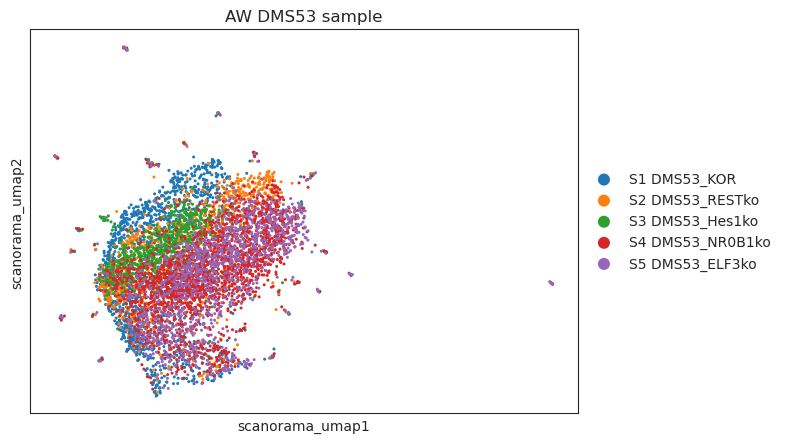

In [32]:
sc.pl.scatter(adata_dk, basis='scanorama_umap',color='AW_DMS53_sample')

In [35]:
adata_SC

AnnData object with n_obs × n_vars = 20301 × 15746
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'AW_DMS53_sample', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'cline', 'initial_size_spliced', 'initial_size_unspliced', 'doublet_scores', 'predicted_doublets', 'doublet_scores_ind', 'predicted_doublets_ind', 'M', 'E', 'clusters_gradients', 'cell_cycle_diff', 'score', 'sample'
    var: 'mito', 'dropkick_coef-S1 DMS53_KOR-AW_DMS53_sample', 'dropkick_coef-S2 DMS53_RESTko-AW_DMS53_sample', 'dropkick_coef-S3 DMS53_Hes1ko-AW_DMS53_sample', 'dropkick_coef-S4 DMS53_NR0B1ko-AW_DMS53_sample', 'dropkick_coef-S5 DMS53_ELF3ko-AW_DMS53_sample', 'pct_dropout_by_counts-AW_DMS53_sample', 'ambient-AW_DMS53_sample', 'n_cells_b

In [ ]:
sc.pp.neighbors(adata_SC, use_rep="X_scanorama", key_added='scanorama_neighbors')

In [37]:
temp = sc.tl.umap(adata_SC, neighbors_key='scanorama_neighbors', random_state=0, copy=True)
adata_SC.obsm['X_scanorama_umap'] = temp.obsm['X_umap']
del temp

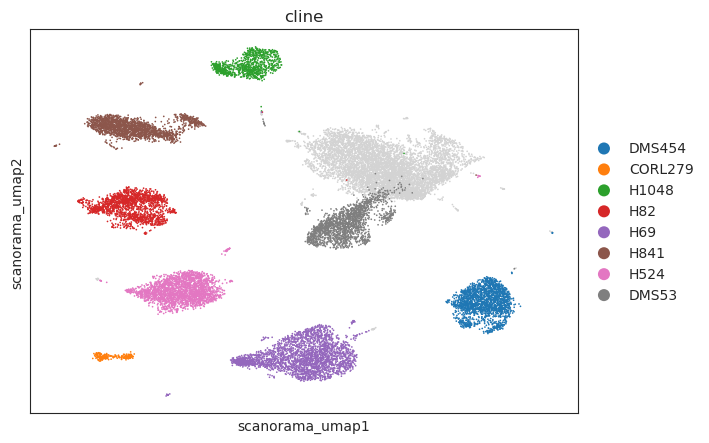

In [45]:
sc.pl.scatter(adata_SC, basis='scanorama_umap',color='cline', save='_all_cell_lines.png')

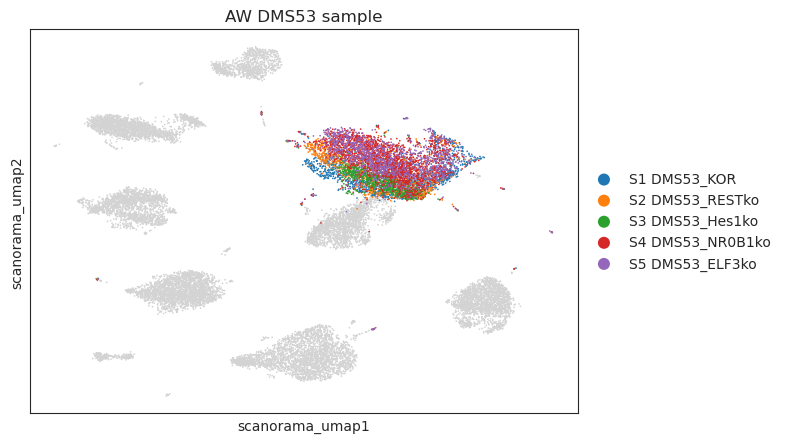

In [46]:
sc.pl.scatter(adata_SC, basis='scanorama_umap',color=['AW_DMS53_sample'], save='_clayton_all_DMS53.png')

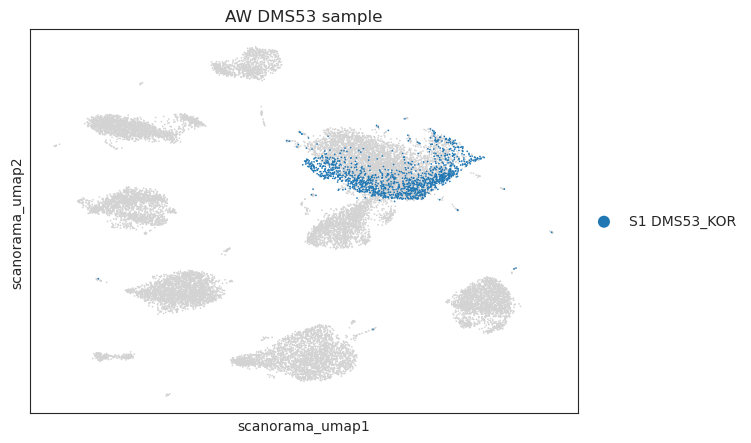

In [44]:
sc.pl.scatter(adata_SC, basis='scanorama_umap',color=['AW_DMS53_sample'], groups='S1 DMS53_KOR', save='DMS53_KOR.png')